# Unsupervised Learning Trading Strategy



*   Download/Load SP500 Stock Data
*   Calculate Different Features and Indicators on Each Stock"



## 1. Download/Load SP500 Stock Prices Data

In [1]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=cd38a89b1d1cdbdcce0790cacc6acf29c63f4b570b8cfe79bb76ec397dba12d3
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]

sp500["Symbol"] = sp500['Symbol'].str.replace('.','-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2025-01-05'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date,
                 auto_adjust=False)

df = df.stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[**********************62%*****                  ]  311 of 503 completedERROR:yfinance:Could not get exchangeTimezoneName for ticker 'NUE' reason: 'chart'
[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NUE']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [5]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-01-09 A        45.296406   48.139999   48.560001   47.910000   48.009998   
           AAPL     27.549496   29.747499   29.857500   29.485001   29.487499   
           ABBV     45.541969   64.209999   64.379997   63.750000   63.799999   
           ABT      35.250351   40.740002   41.060001   40.619999   40.790001   
           ACGL     27.011858   28.406668   28.740000   28.070000   28.740000   
...                       ...         ...         ...         ...         ...   
2025-01-03 XYL     117.180000  117.180000  117.800003  116.169998  116.169998   
           YUM     133.440002  133.440002  134.000000  132.369995  133.660004   
           ZBH     104.470001  104.470001  104.599998  102.980003  104.519997   
           ZBRA    391.859985  391.859985  392.500000  383.029999  383.029999   
           ZTS     163.309998  163.309998  163.869995  160.589996  162.240005   

Price                   volume  
date       ticker               
2017-01-09 A         2575300.0  
           AAPL    134247600.0  
           ABBV      8794500.0  
           ABT      10992500.0  
           ACGL      1866300.0  
...                        ...  
2025-01-03 XYL        816600.0  
           YUM       1154300.0  
           ZBH       1253700.0  
           ZBRA       357900.0  
           ZTS       2206400.0  

[989332 rows x 6 columns]

## 2. Calculate Features and Technical Indicators for Each Stock



*   Garman-Klass Volatility
*   RSI
*   Bollinger Bands
*   ATR
*   MACD
*   Dollar Volume

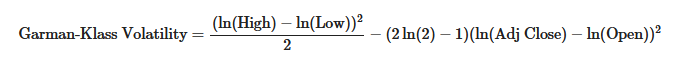





In [6]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-01-09 A        45.296406   48.139999   48.560001   47.910000   48.009998   
           AAPL     27.549496   29.747499   29.857500   29.485001   29.487499   
           ABBV     45.541969   64.209999   64.379997   63.750000   63.799999   
           ABT      35.250351   40.740002   41.060001   40.619999   40.790001   
           ACGL     27.011858   28.406668   28.740000   28.070000   28.740000   
...                       ...         ...         ...         ...         ...   
2025-01-03 XYL     117.180000  117.180000  117.800003  116.169998  116.169998   
           YUM     133.440002  133.440002  134.000000  132.369995  133.660004   
           ZBH     104.470001  104.470001  104.599998  102.980003  104.519997   
           ZBRA    391.859985  391.859985  392.500000  383.029999  383.029999   
           ZTS     163.309998  163.309998  163.869995  160.589996  162.240005   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2017-01-09 A         2575300.0         -0.001217        NaN       NaN   
           AAPL    134247600.0         -0.001706        NaN       NaN   
           ABBV      8794500.0         -0.043854        NaN       NaN   
           ABT      10992500.0         -0.008172        NaN       NaN   
           ACGL      1866300.0         -0.001207        NaN       NaN   
...                        ...               ...        ...       ...   
2025-01-03 XYL        816600.0          0.000068  38.489767  4.728608   
           YUM       1154300.0          0.000074  46.340588  4.878307   
           ZBH       1253700.0          0.000122  41.304873  4.655833   
           ZBRA       357900.0          0.000098  50.039694  5.938235   
           ZTS       2206400.0          0.000188  35.219809  5.064913   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-01-09 A            NaN       NaN       NaN       NaN     116.651834  
           AAPL         NaN       NaN       NaN       NaN    3698.453679  
           ABBV         NaN       NaN       NaN       NaN     400.518849  
           ABT          NaN       NaN       NaN       NaN     387.489483  
           ACGL         NaN       NaN       NaN       NaN      50.412231  
...                     ...       ...       ...       ...            ...  
2025-01-03 XYL     4.797138  4.865668  0.286496 -1.564363      95.689188  
           YUM     4.914682  4.951057  0.490143 -0.590524     154.029795  
           ZBH     4.679093  4.702353 -0.701401 -0.410849     130.974041  
           ZBRA    5.984200  6.030164  0.111109 -0.427094     140.246689  
           ZTS     5.138767  5.212621  0.267335 -1.762841     360.327179  

[989332 rows x 14 columns]

## 3. Aggregate to Monthly Lvel and filter the top 150 liquid stocks for each month

This is done to reduce training time and experiement with the features we developed above, converting the business-daily data to month-end

In [7]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-02-28 A           98.277652   48.269737         -0.001607  62.021403   
           AAPL      3730.196712   31.854506         -0.002049  88.376396   
           ABBV       293.042515   44.303562         -0.044025  51.263452   
           ABT        332.530620   39.257484         -0.008100  74.444818   
           ACGL        34.503753   29.975491         -0.000539  80.090693   
...                          ...         ...               ...        ...   
2025-01-31 KVUE       152.261021   21.200001          0.000060  35.050679   
           VLTO       111.659183  100.800003          0.000086  39.431134   
           GEV        842.268005  354.029999          0.000700  59.144339   
           SOLV        43.599126   67.120003          0.000205  43.620645   
           SW         158.700876   52.299999          0.000189  48.016691   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-02-28 A       3.844027  3.881775  3.919523 -1.573138  0.299293  
           AAPL    3.400463  3.462253  3.524044 -1.466095  0.152970  
           ABBV    3.784566  3.803218  3.821869 -1.782094 -0.201696  
           ABT     3.609819  3.664647  3.719474 -1.567830  0.656320  
           ACGL    3.373374  3.412252  3.451130 -1.195950  0.413875  
...                     ...       ...       ...       ...       ...  
2025-01-31 KVUE    3.082315  3.132307  3.182298 -0.671143 -1.124968  
           VLTO    4.613879  4.649759  4.685638 -0.268124 -1.585795  
           GEV     5.769899  5.822714  5.875528  1.906352 -0.707728  
           SOLV    4.186540  4.234084  4.281629 -1.747115 -0.793745  
           SW      3.966375  4.000784  4.035193 -1.058289 -0.209593  

[47252 rows x 9 columns]

### Calculating the 5-year rolling average of dollar volume for each stocks before filtering

In [8]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAPL     39.388092         -0.001208  40.100778  3.695993   
           ABBV     83.089935         -0.042428  62.305742  4.236627   
           ABT      55.295002         -0.005933  69.275039  3.936872   
           ACN     144.842712         -0.003841  63.135538  4.952747   
           ADBE    199.759995          0.000156  65.801039  5.203949   
...                       ...               ...        ...       ...   
2025-01-31 CRWD    359.019989          0.000251  53.658492  5.829136   
           PLTR     79.889999          0.000609  64.292961  4.252934   
           ABNB    135.710007          0.000243  52.159428  4.860304   
           CEG     252.399994          0.000756  57.299354  5.383777   
           KVUE     21.200001          0.000060  35.050679  3.082315   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-01-31 AAPL    3.736405  3.776816 -1.255840 -0.432747  
           ABBV    4.368567  4.500507  1.174739  1.688436  
           ABT     3.995678  4.054483 -0.931702  0.890998  
           ACN     4.976202  4.999656 -1.254018  0.242808  
           ADBE    5.268046  5.332143 -1.294942  0.410173  
...                     ...       ...       ...       ...  
2025-01-31 CRWD    5.888391  5.947645  1.363202  0.022618  
           PLTR    4.344017  4.435100  4.083817  2.564923  
           ABNB    4.905111  4.949919 -0.808252 -0.138709  
           CEG     5.464361  5.544944  1.604644 -0.859807  
           KVUE    3.132307  3.182298 -0.671143 -1.124968  

[12665 rows x 8 columns]

## 4. Calculate Monthly Returns for Different Time Horizons as Features

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various montly period as identified by lags

In [9]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-01-31 AAPL     39.743027         -0.000391  53.482555  3.564609   
           ABBV     62.078812         -0.021799  41.951179  4.108503   
           ABT      66.100258         -0.001865  56.879216  4.115729   
           ACN     140.895615         -0.002769  55.082675  4.855345   
           ADBE    247.820007          0.000148  56.084696  5.412191   
...                       ...               ...        ...       ...   
2025-01-31 MRNA     42.180000          0.000676  45.766352  3.662385   
           UBER     64.589996          0.000307  46.631943  4.083530   
           CRWD    359.019989          0.000251  53.658492  5.829136   
           PLTR     79.889999          0.000609  64.292961  4.252934   
           ABNB    135.710007          0.000243  52.159428  4.860304   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-01-31 AAPL    3.630896  3.697183 -0.874274 -0.384100   0.055154   
           ABBV    4.201370  4.294236  0.336683 -1.043373  -0.118399   
           ABT     4.161145  4.206561 -0.070311  0.142990   0.013665   
           ACN     4.915819  4.976293 -0.777071  0.042371   0.088930   
           ADBE    5.478527  5.544863 -0.681212  0.207993   0.095385   
...                     ...       ...       ...       ...        ...   
2025-01-31 MRNA    3.745709  3.829034 -0.795771 -0.123032   0.014430   
           UBER    4.145122  4.206714  0.456978 -1.435607   0.070789   
           CRWD    5.888391  5.947645  1.363202  0.022618   0.049275   
           PLTR    4.344017  4.435100  4.083817  2.564923   0.056327   
           ABNB    4.905111  4.949919 -0.808252 -0.138709   0.032722   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-01-31 AAPL    -0.034589  -0.086165  -0.020933   0.001996    0.000748  
           ABBV    -0.071480   0.014454  -0.019116  -0.016684   -0.024001  
           ABT     -0.004952   0.020737   0.019565   0.027107    0.014985  
           ACN     -0.033914  -0.008682  -0.004631   0.002728   -0.002300  
           ADBE    -0.006137   0.002786   0.002128   0.012503    0.018128  
...                      ...        ...        ...        ...         ...  
2025-01-31 MRNA    -0.010271  -0.081084  -0.159006  -0.101309   -0.070219  
           UBER    -0.052592  -0.035778   0.000310  -0.002849   -0.000872  
           CRWD     0.018685   0.065412   0.075518   0.023014    0.017223  
           PLTR     0.091314   0.243385   0.198994   0.152378    0.141403  
           ABNB    -0.001470   0.002270  -0.004652  -0.017149   -0.005009  

[10503 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.


We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.


In [10]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV     0.084  0.0301 -0.0045 -0.0078 -0.0152  -0.118399
           ABT      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.013665
           ACN      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.088930
           ADBE     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.095385
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ       0.065  0.0478 -0.0005 -0.0261 -0.0217   0.052457
           WDAY     0.065  0.0478 -0.0005 -0.0261 -0.0217   0.069019
           WFC      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.180051
           WMT      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.128578
           XOM      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.018405

[10221 rows x 6 columns]

Filtering out Stocks with less than 10 months of data

In [11]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV     0.084  0.0301 -0.0045 -0.0078 -0.0152  -0.118399
           ABT      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.013665
           ACN      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.088930
           ADBE     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.095385
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ       0.065  0.0478 -0.0005 -0.0261 -0.0217   0.052457
           WDAY     0.065  0.0478 -0.0005 -0.0261 -0.0217   0.069019
           WFC      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.180051
           WMT      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.128578
           XOM      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.018405

[10196 rows x 6 columns]

Calculating Rolling Factor Betas

In [12]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-01-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-11-30 VZ      0.885446 -0.606383  0.298892  0.506045  0.276627
           WDAY    0.760453 -1.023488  0.151870 -2.489189 -0.729128
           WFC     0.723451 -0.312081  1.429828 -2.012390 -1.095390
           WMT     0.844559  0.175822 -0.332755  1.279653  0.295548
           XOM     0.614447  0.031140  0.205420  1.179329  0.728194

[10196 rows x 5 columns]

In [13]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10267 entries, (Timestamp('2019-01-31 00:00:00'), 'AAPL') to (Timestamp('2025-01-31 00:00:00'), 'PLTR')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10267 non-null  float64
 1   rsi               10267 non-null  float64
 2   bb_low            10267 non-null  float64
 3   bb_mid            10267 non-null  float64
 4   bb_high           10267 non-null  float64
 5   atr               10267 non-null  float64
 6   macd              10267 non-null  float64
 7   return_1m         10267 non-null  float64
 8   return_2m         10267 non-null  float64
 9   return_3m         10267 non-null  float64
 10  return_6m         10267 non-null  float64
 11  return_9m         10267 non-null  float64
 12  return_12m        10267 non-null  float64
 13  Mkt-RF            10267 non-null  float64
 14  SMB               10267 non-null  float64
 15  HML      

## Now we have to decide what ML model we should use for predictions

## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

In [20]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-01-31 AAPL           -0.000391  53.482555  3.564609  3.630896  3.697183   
           ABBV           -0.021799  41.951179  4.108503  4.201370  4.294236   
           ABT            -0.001865  56.879216  4.115729  4.161145  4.206561   
           ACN            -0.002769  55.082675  4.855345  4.915819  4.976293   
           ADBE            0.000148  56.084696  5.412191  5.478527  5.544863   
...                             ...        ...       ...       ...       ...   
2025-01-31 XOM             0.000045  37.208479  4.645205  4.698733  4.752261   
           MRNA            0.000676  45.766352  3.662385  3.745709  3.829034   
           UBER            0.000307  46.631943  4.083530  4.145122  4.206714   
           CRWD            0.000251  53.658492  5.829136  5.888391  5.947645   
           PLTR            0.000609  64.292961  4.252934  4.344017  4.435100   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-01-31 AAPL   -0.874274 -0.384100   0.055154  -0.034589  -0.086165   
           ABBV    0.336683 -1.043373  -0.118399  -0.071480   0.014454   
           ABT    -0.070311  0.142990   0.013665  -0.004952   0.020737   
           ACN    -0.777071  0.042371   0.088930  -0.033914  -0.008682   
           ADBE   -0.681212  0.207993   0.095385  -0.006137   0.002786   
...                     ...       ...        ...        ...        ...   
2025-01-31 XOM     0.056376 -2.109434   0.002696  -0.043769  -0.023478   
           MRNA   -0.795771 -0.123032   0.014430  -0.010271  -0.081084   
           UBER    0.456978 -1.435607   0.070789  -0.052592  -0.035778   
           CRWD    1.363202  0.022618   0.049275   0.018685   0.065412   
           PLTR    4.083817  2.564923   0.056327   0.091314   0.243385   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-01-31 AAPL    -0.020933   0.001996    0.000748  1.284941 -0.213367   
           ABBV    -0.019116  -0.016684   -0.024001  0.542314  0.283109   
           ABT      0.019565   0.027107    0.014985  0.765061 -0.038242   
           ACN     -0.004631   0.002728   -0.002300  1.200646 -0.207665   
           ADBE     0.002128   0.012503    0.018128  1.320398 -0.574325   
...                      ...        ...         ...       ...       ...   
2025-01-31 XOM     -0.013020  -0.007510    0.006814  0.995458  0.039086   
           MRNA    -0.159006  -0.101309   -0.070219  1.342317  0.994290   
           UBER     0.000310  -0.002849   -0.000872  1.360919  0.382226   
           CRWD     0.075518   0.023014    0.017223  0.688608 -1.880495   
           PLTR     0.198994   0.152378    0.141403  1.022013 -0.216265   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-01-31 AAPL   -0.635408  0.321327  0.466806        3  
           ABBV   -0.140993  0.390227  0.526183        0  
           ABT    -0.437837  0.147723  1.010344        3  
           ACN    -0.220429  0.349064 -0.003392        3  
           ADBE   -0.251456  0.315035 -0.421251        3  
...                     ...       ...       ...      ...  
2025-01-31 XOM     0.906307 -0.456892  0.353614        0  
           MRNA   -0.774508  1.350223  0.931493        3  
           UBER   -0.250979 -1.942878 -0.531835        3  
           CRWD    0.325387 -3.237622 -1.854657        2  
           PLTR   -1.450853 -4.939628 -2.308484        1  

[10267 rows x 19 columns]

In [21]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

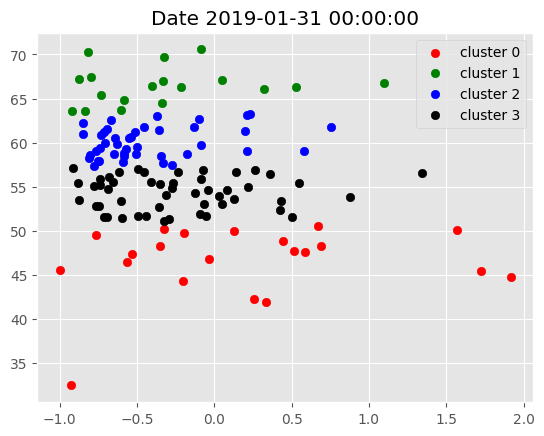

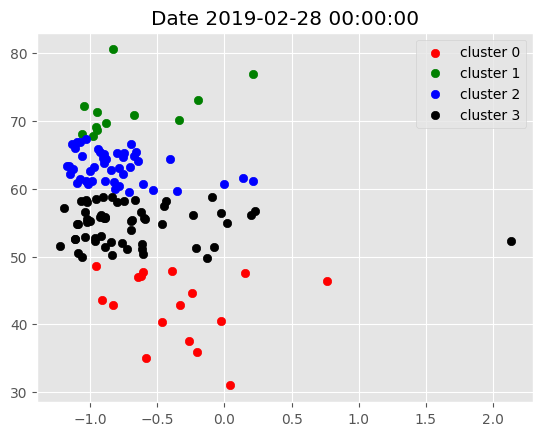

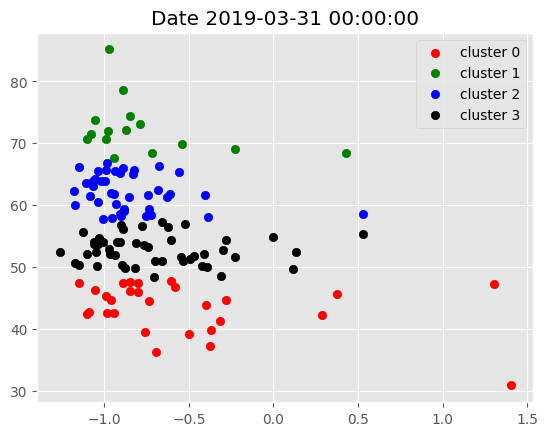

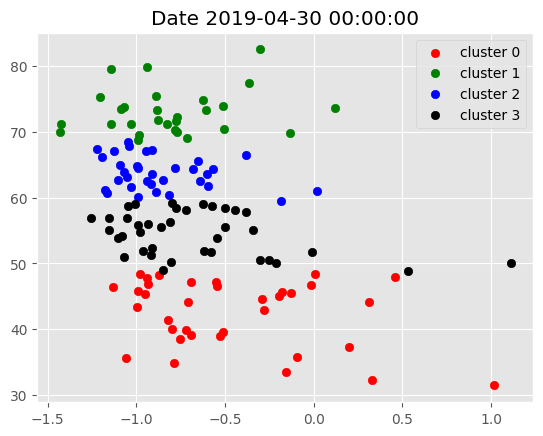

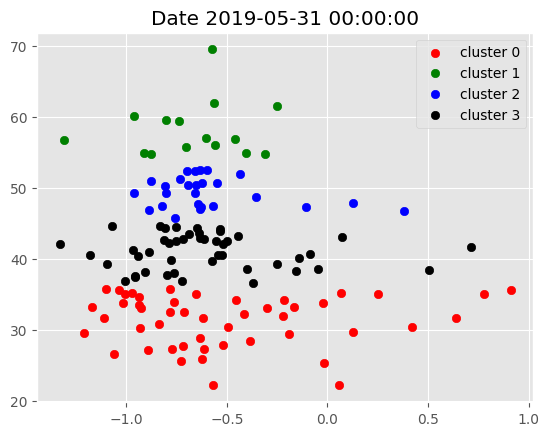

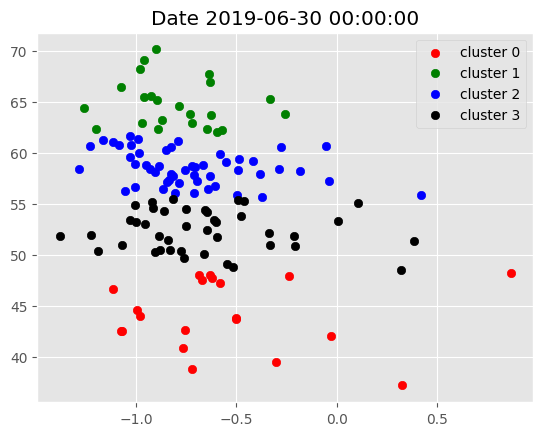

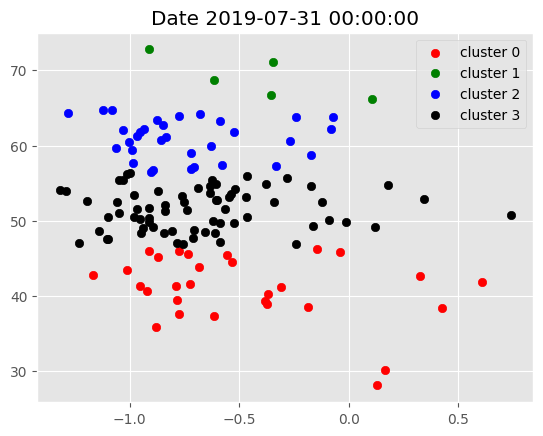

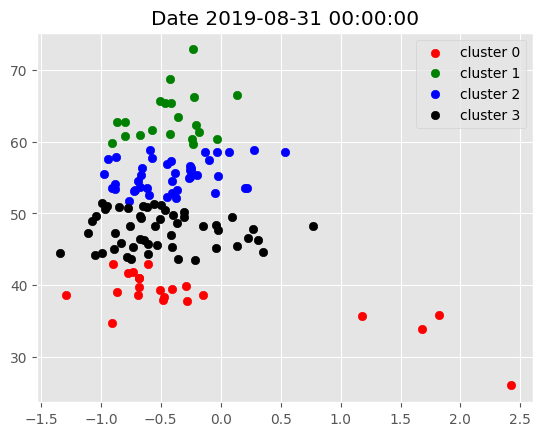

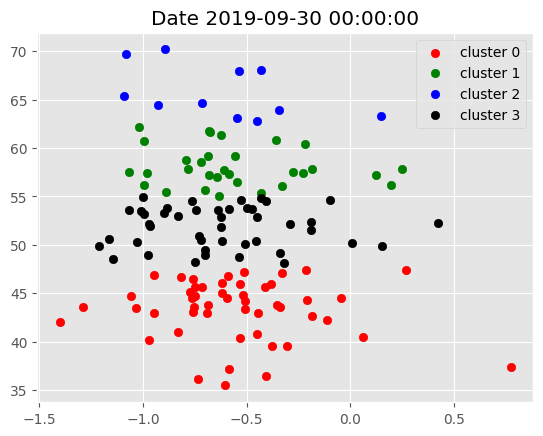

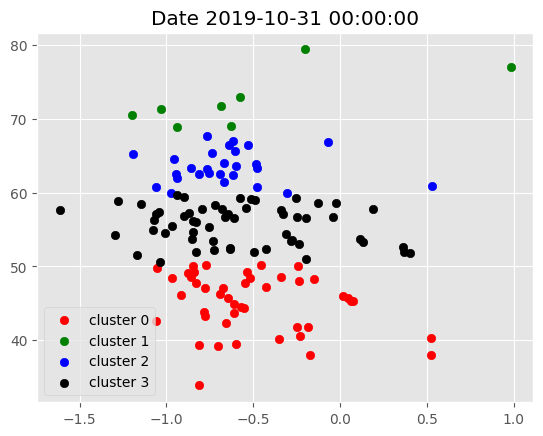

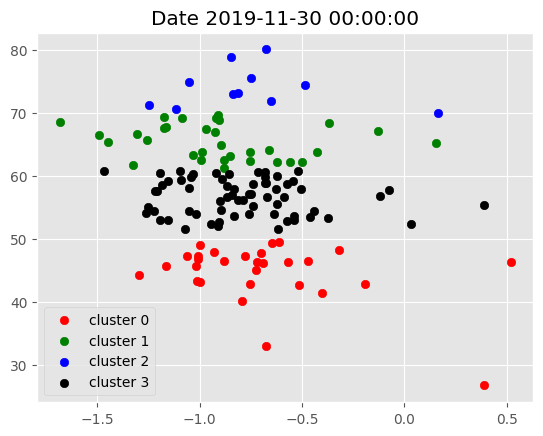

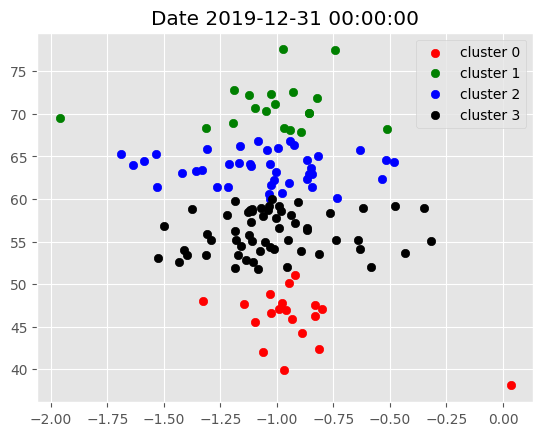

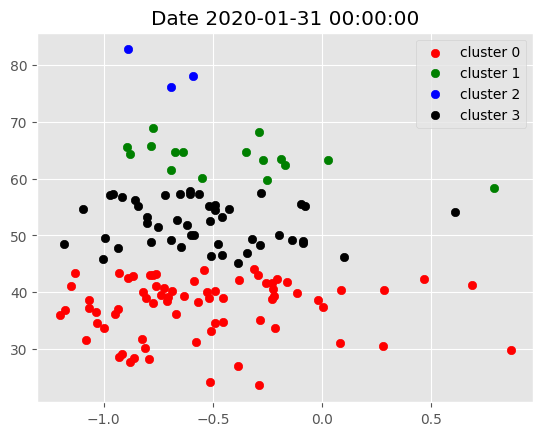

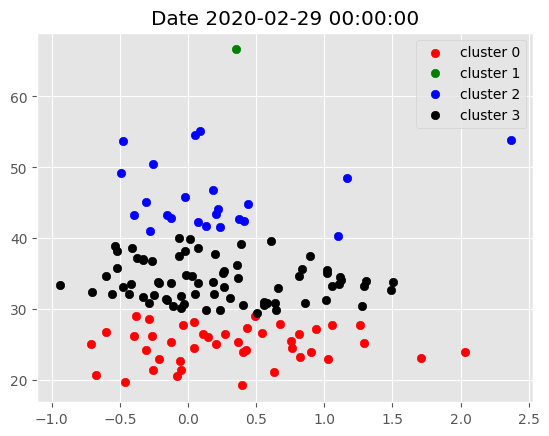

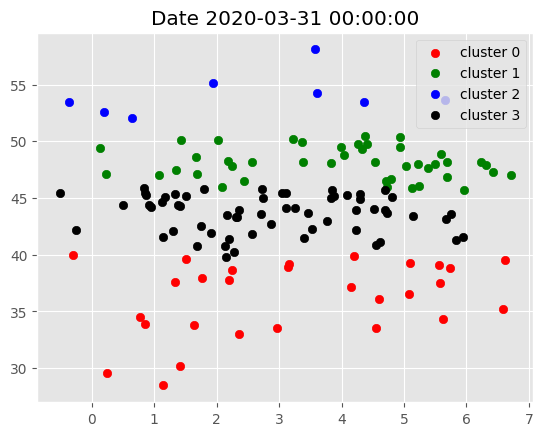

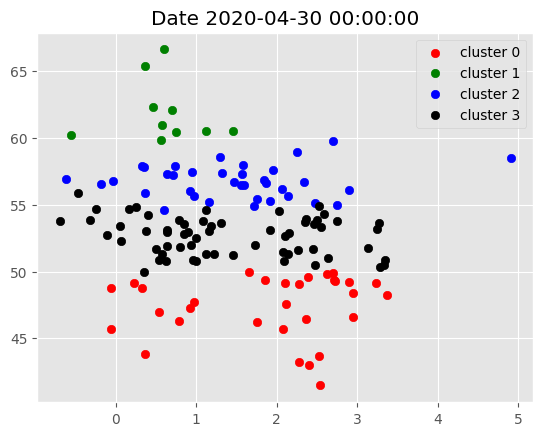

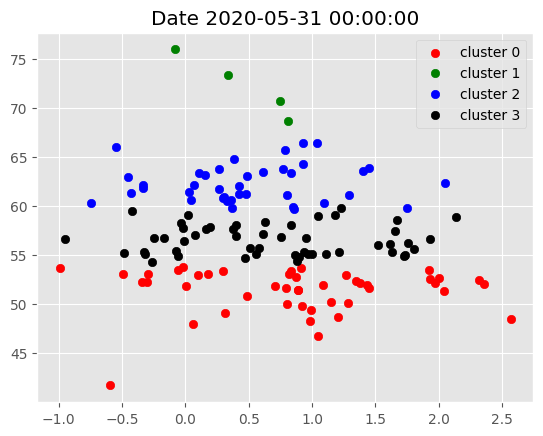

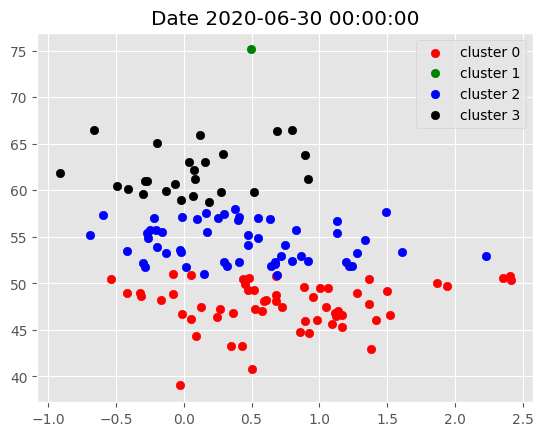

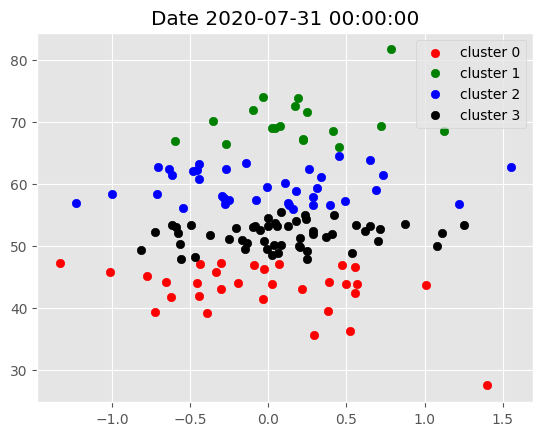

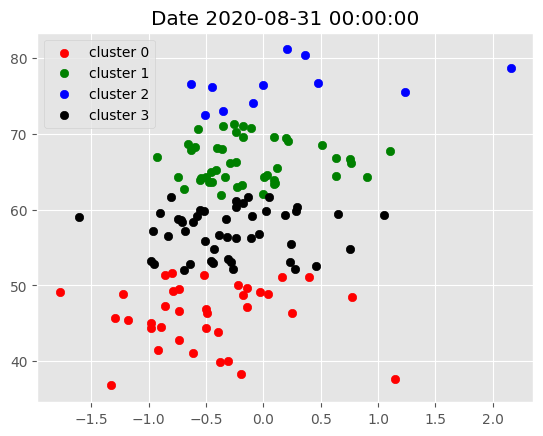

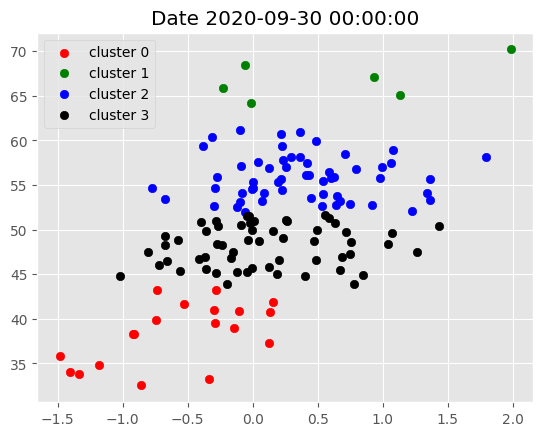

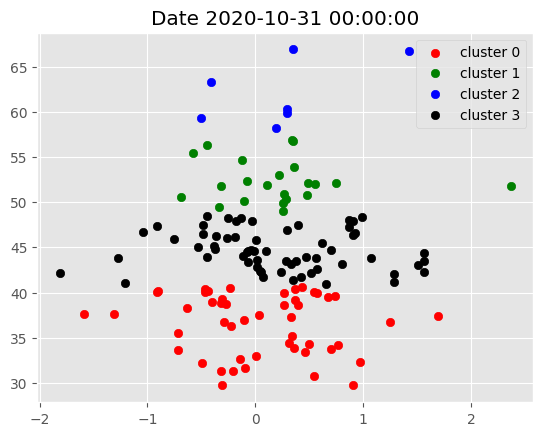

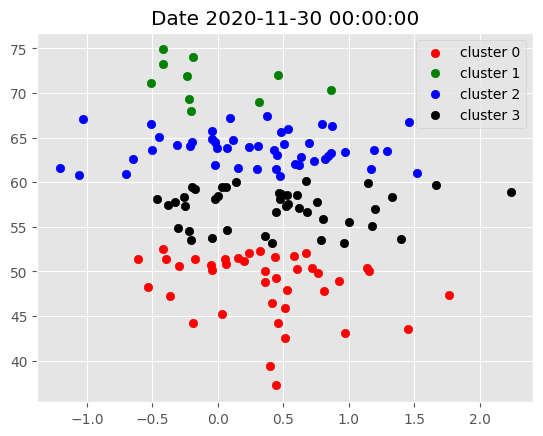

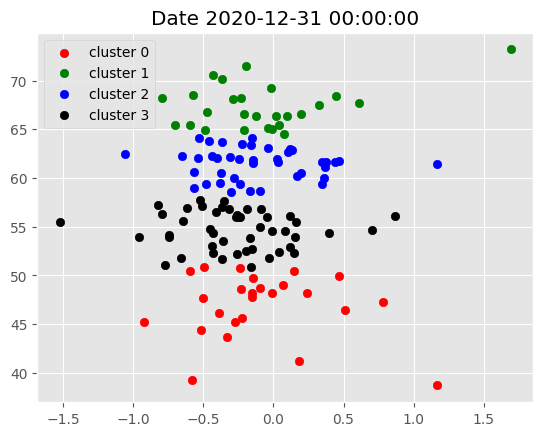

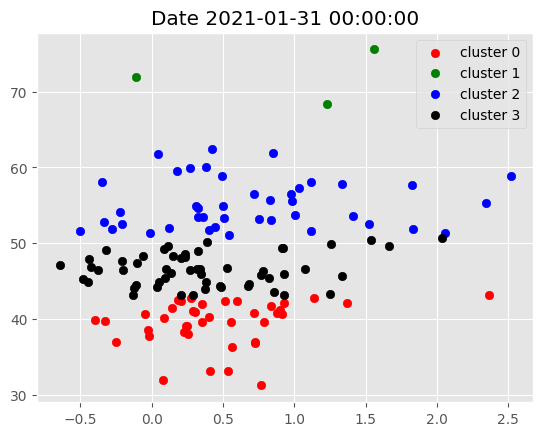

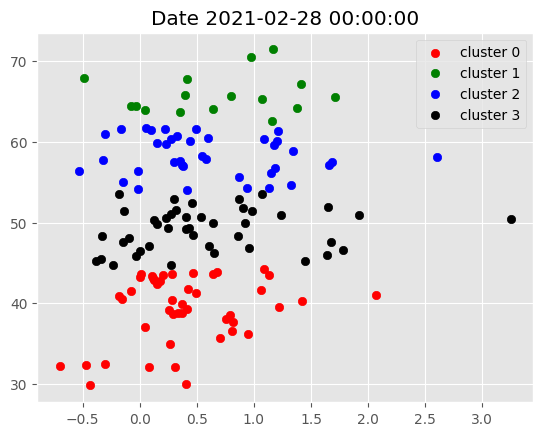

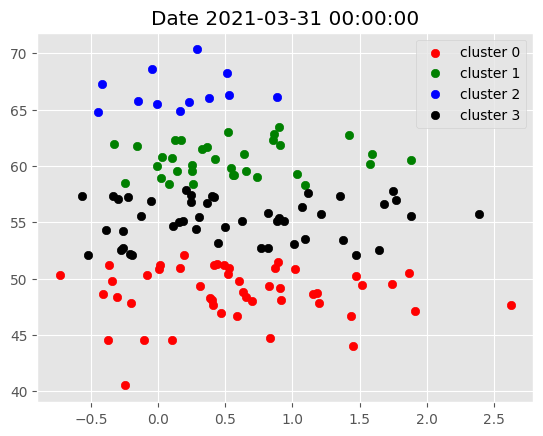

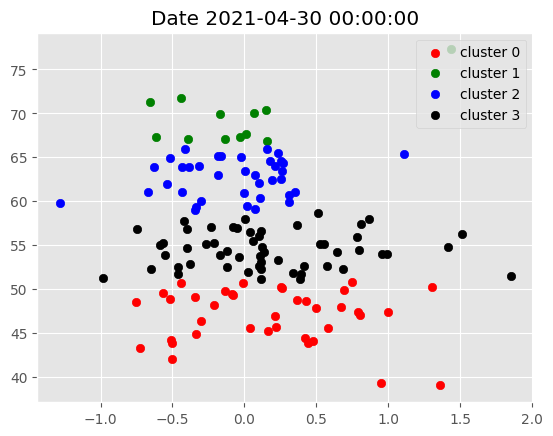

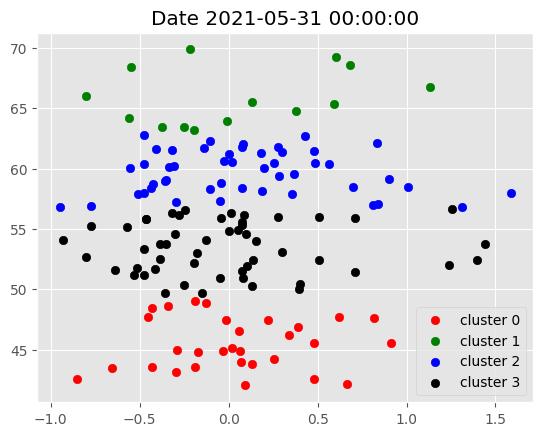

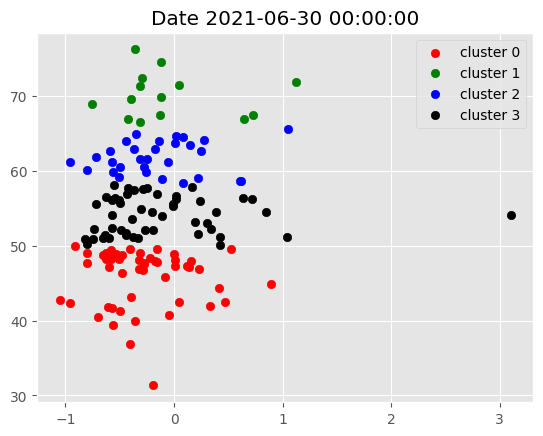

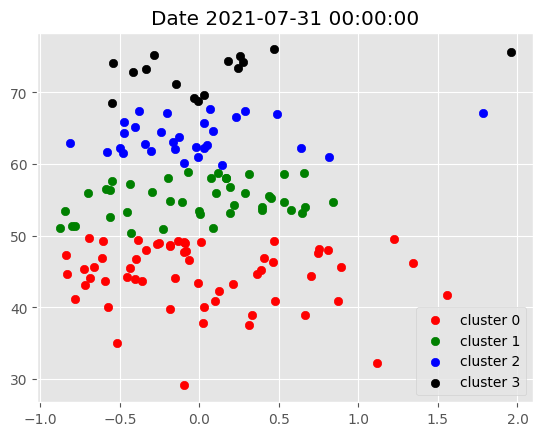

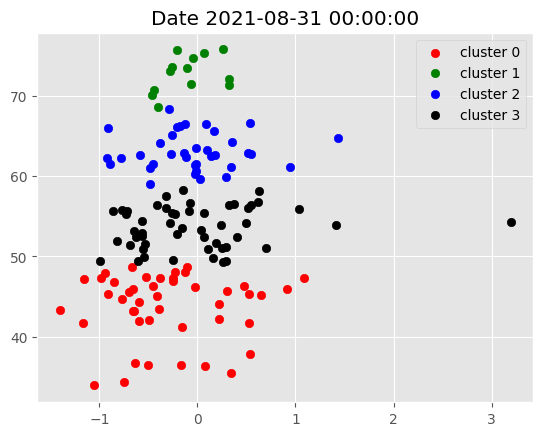

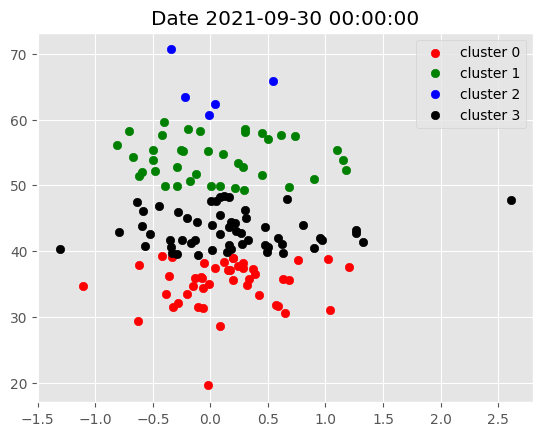

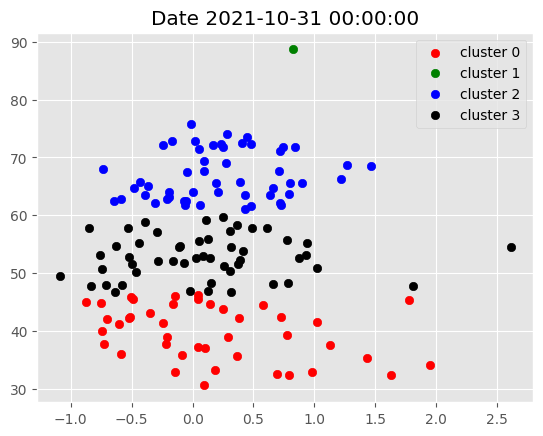

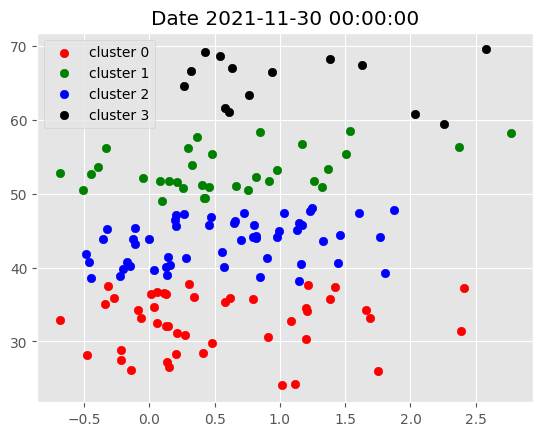

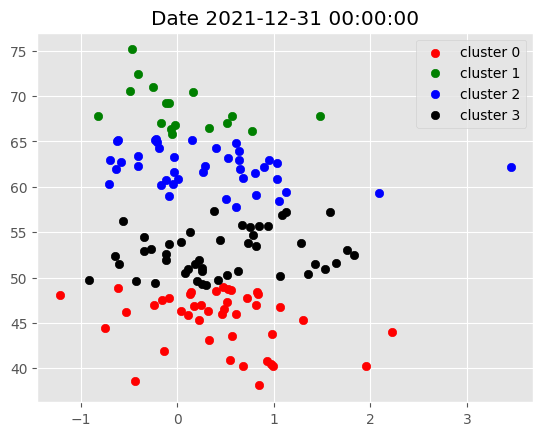

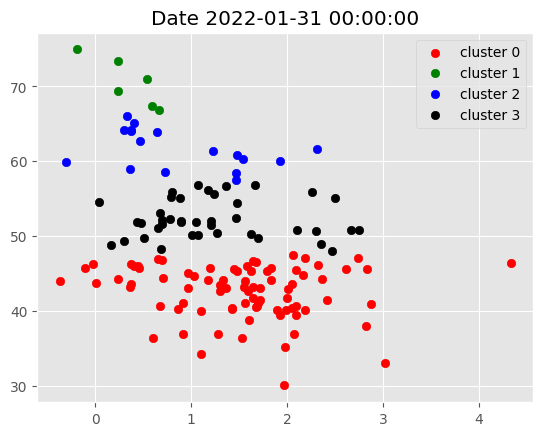

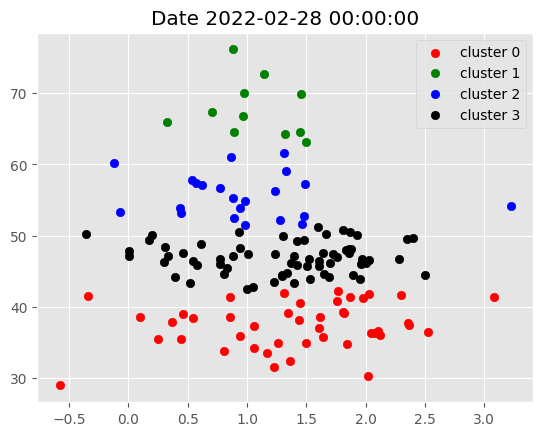

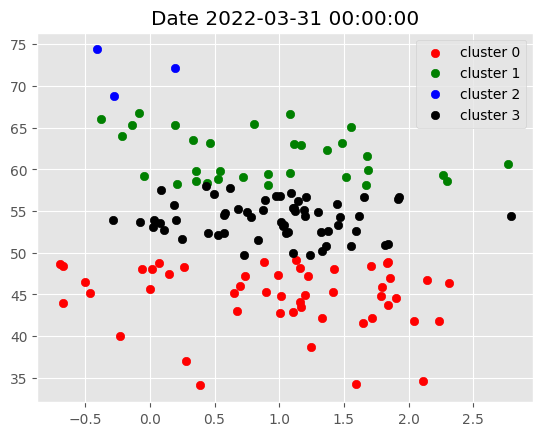

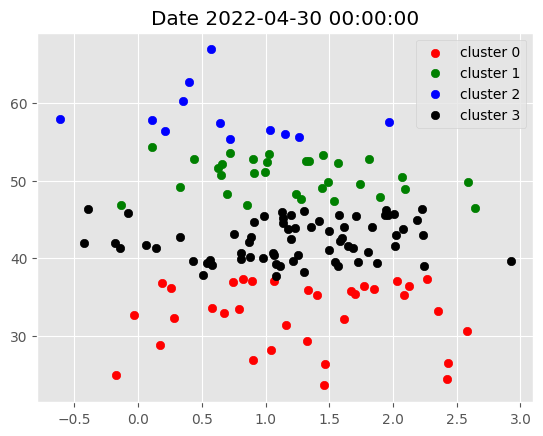

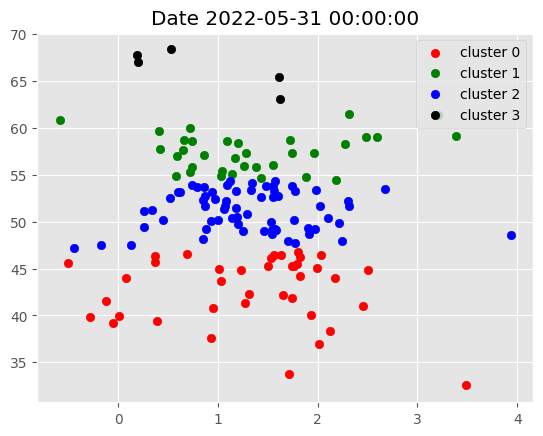

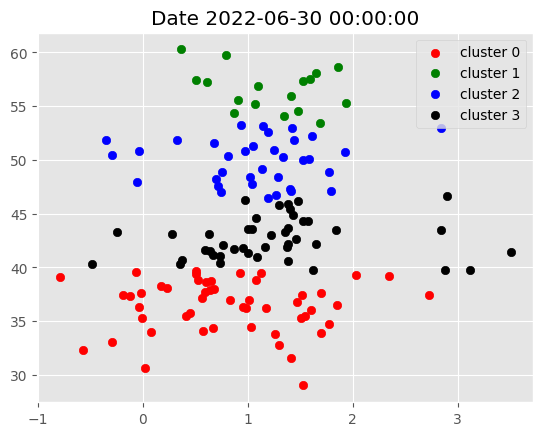

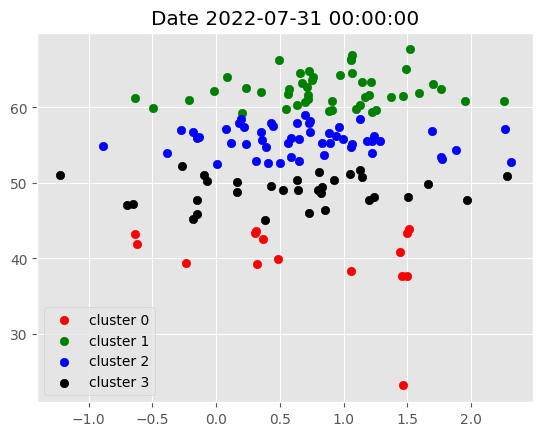

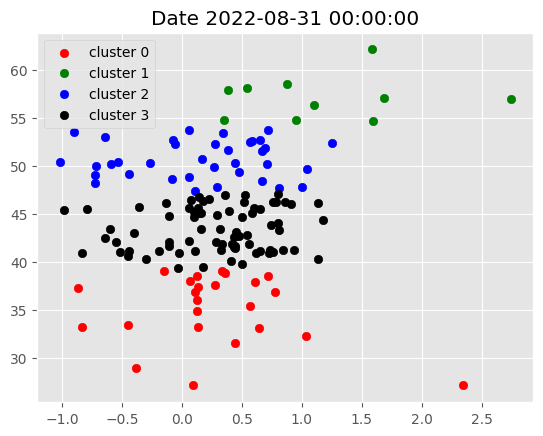

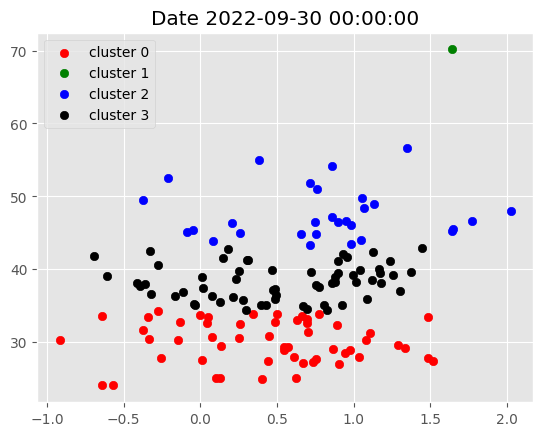

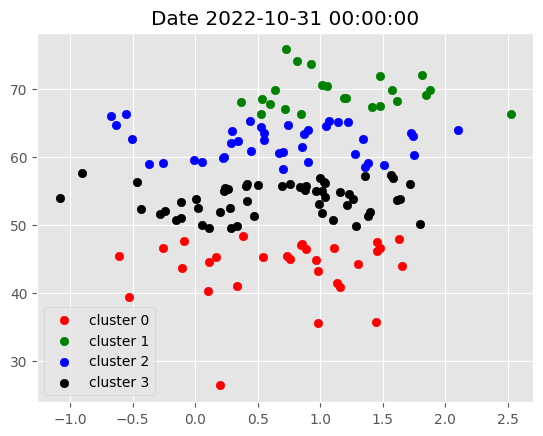

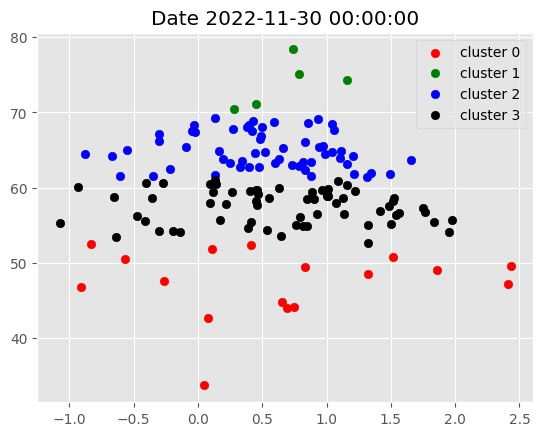

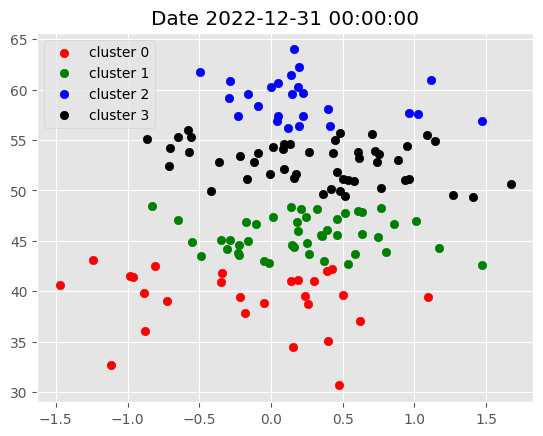

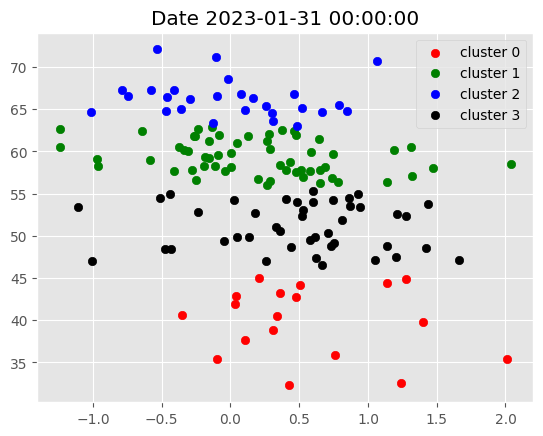

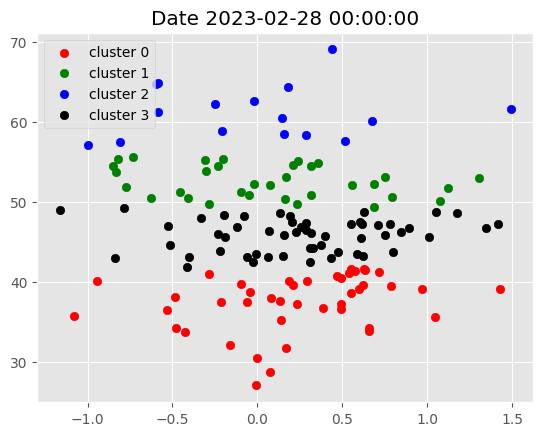

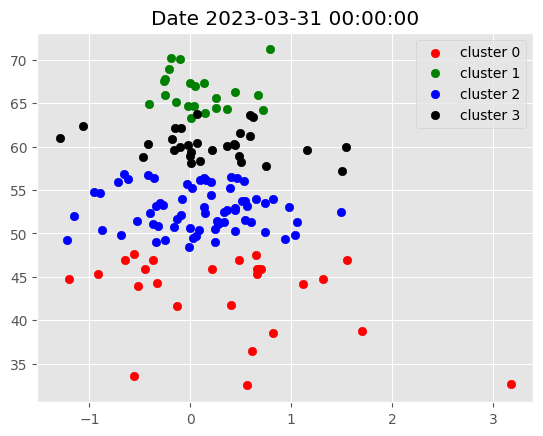

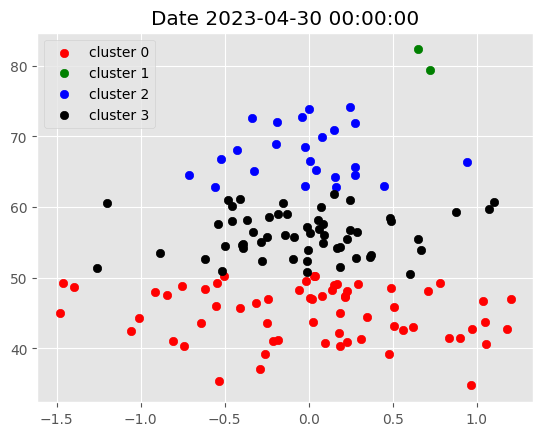

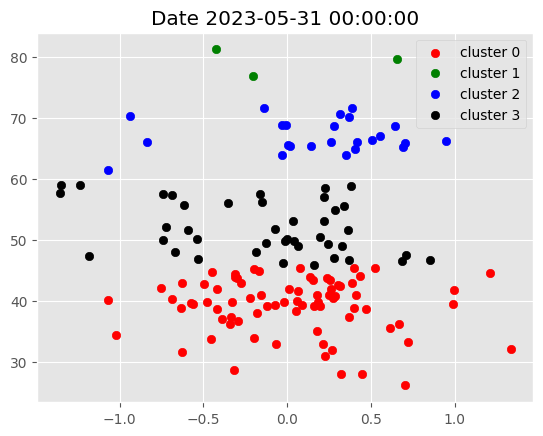

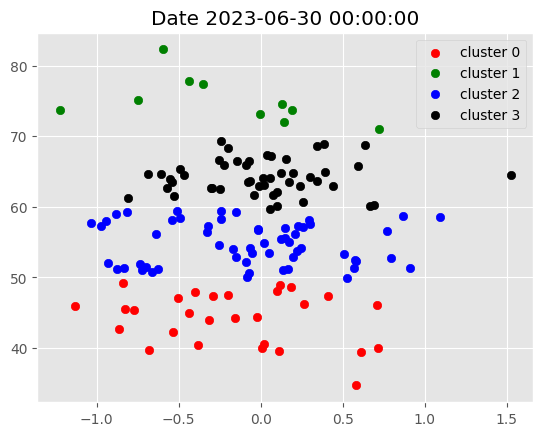

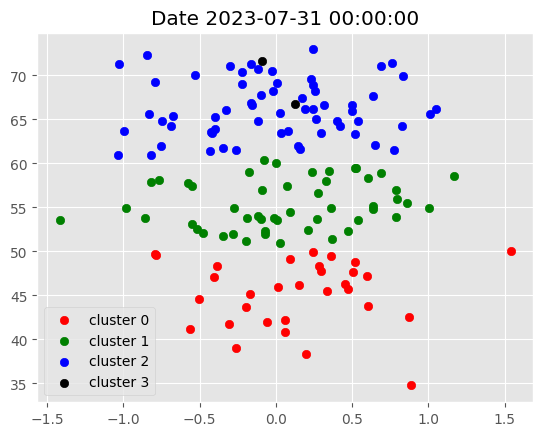

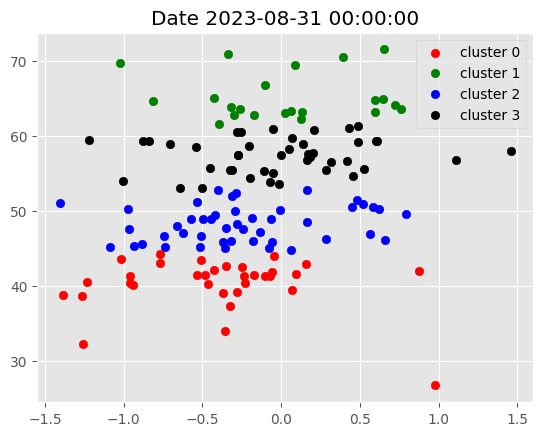

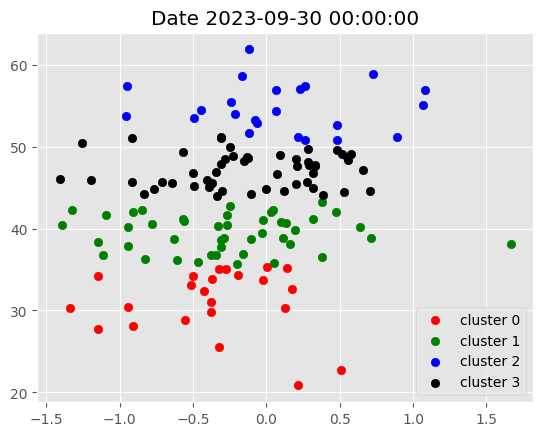

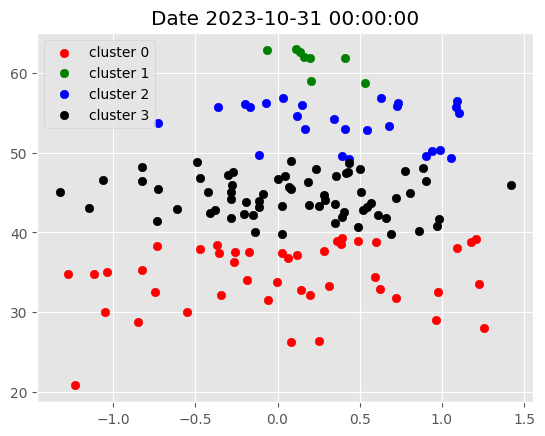

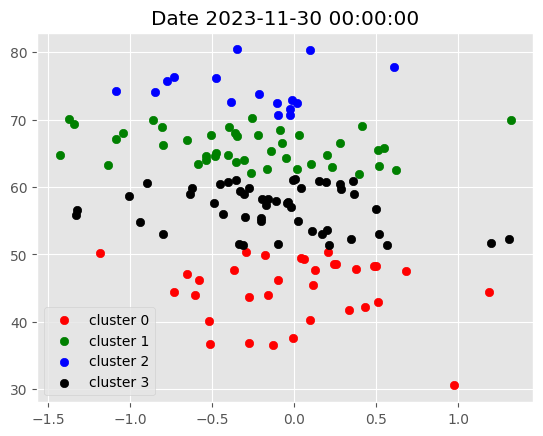

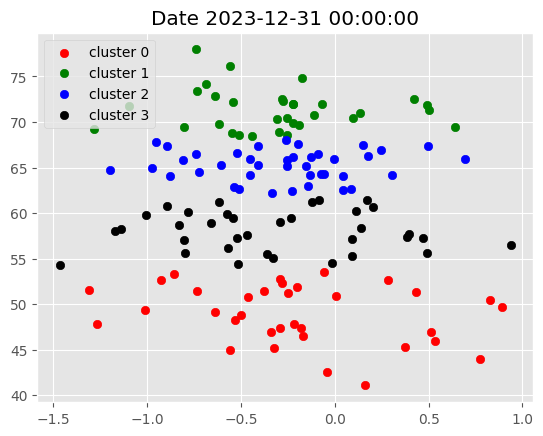

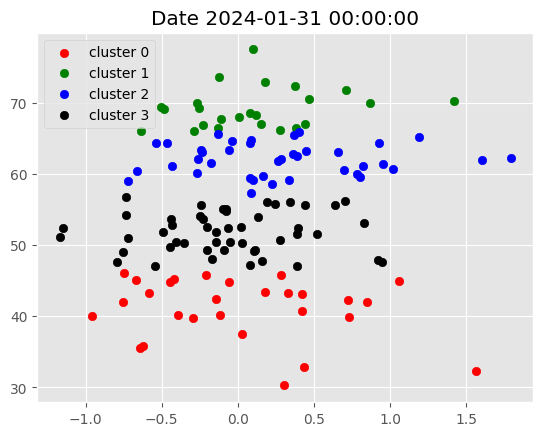

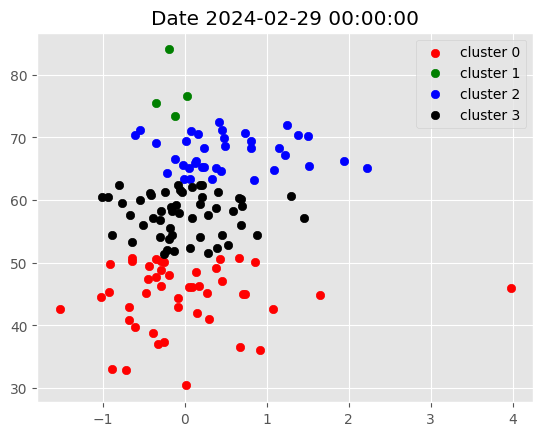

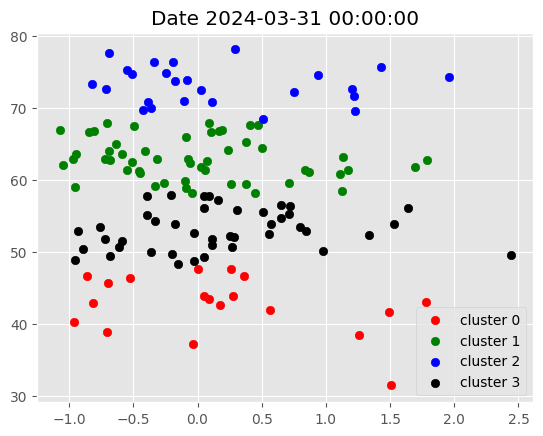

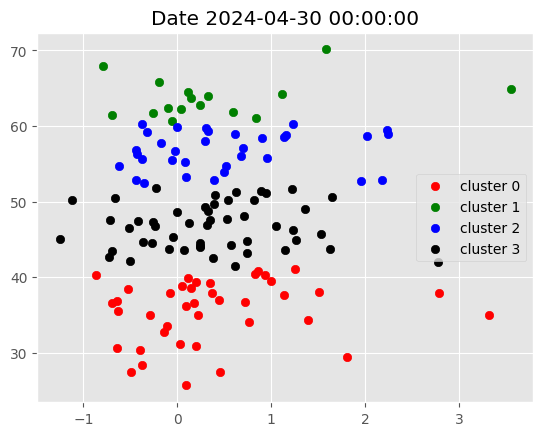

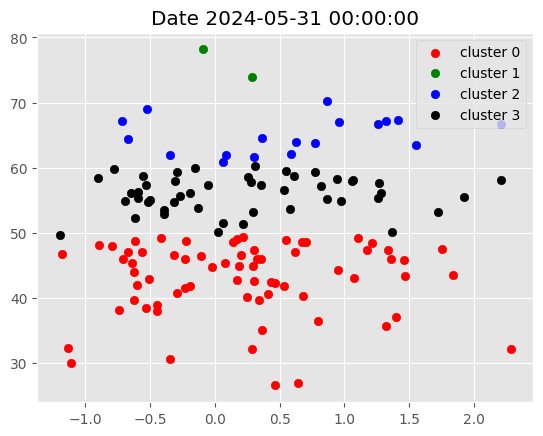

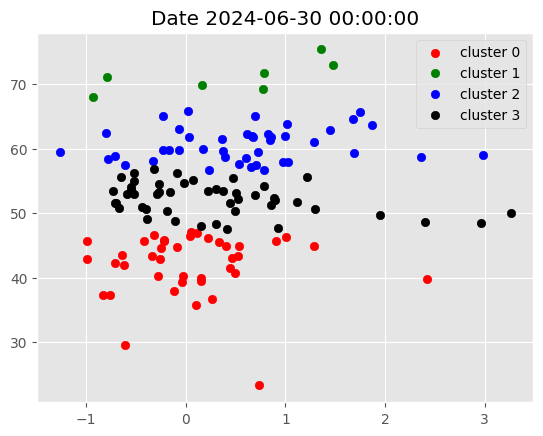

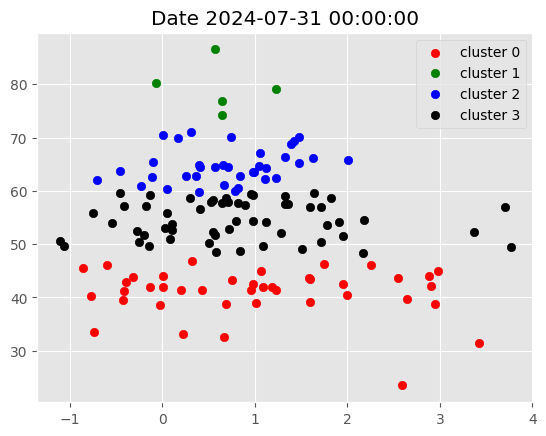

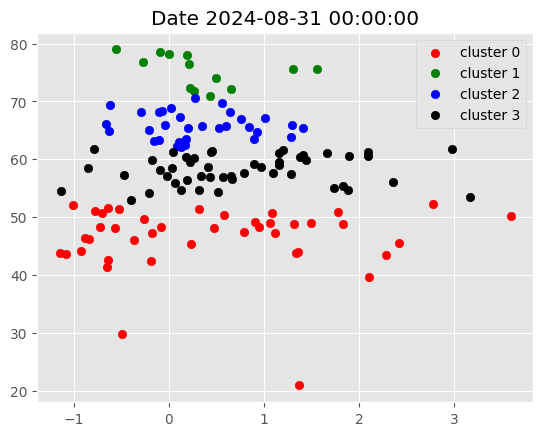

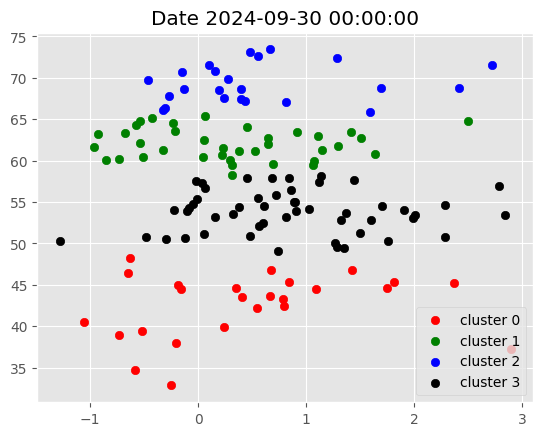

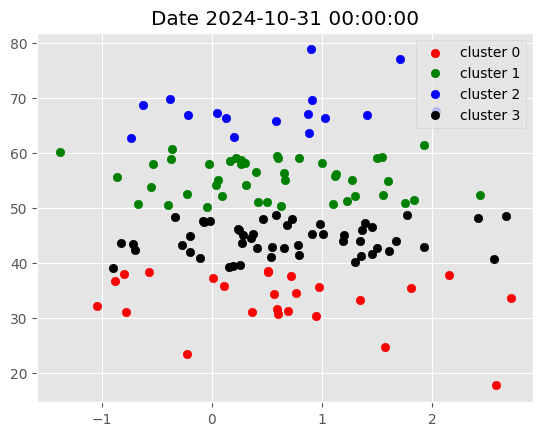

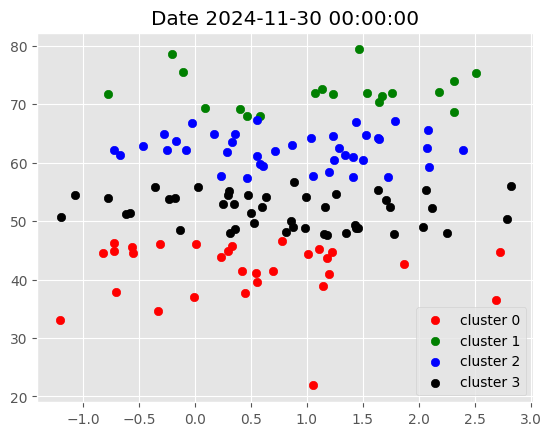

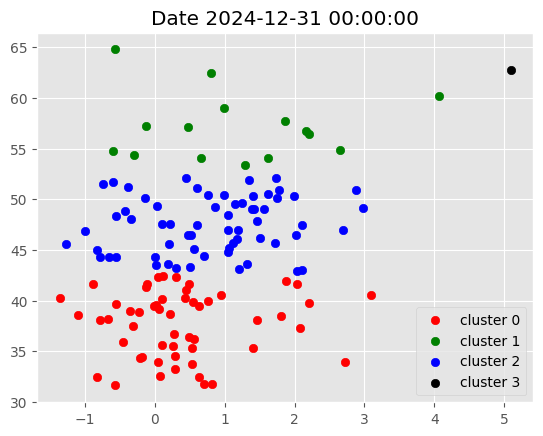

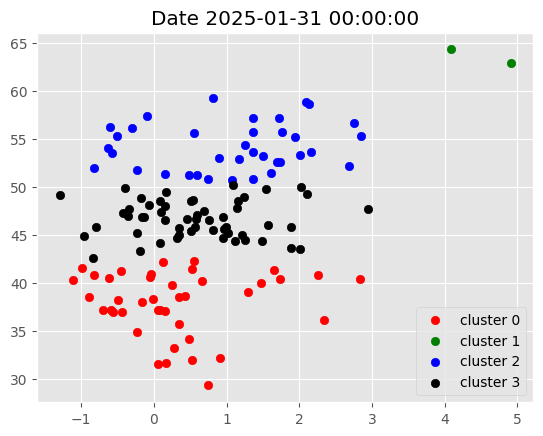

In [22]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

## Apply Pre-Based Centroids

In [19]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization



*   First we filter only stocks corresponding to the cluseter we choose based on our hypothesis
*   Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to ourperform in the following month. - thus I would select stocks corresponding to cluster 3




In [27]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2019-02-01': ['AAPL',
  'ABT',
  'ACN',
  'ADBE',
  'AMZN',
  'AXP',
  'AZO',
  'BIIB',
  'BKNG',
  'BLK',
  'BRK-B',
  'CAT',
  'CI',
  'CMCSA',
  'COP',
  'COST',
  'CVX',
  'DIS',
  'EA',
  'EOG',
  'EXPE',
  'F',
  'FCX',
  'GILD',
  'HAL',
  'ISRG',
  'JNJ',
  'JPM',
  'KO',
  'LMT',
  'LOW',
  'MMM',
  'MS',
  'MU',
  'NEE',
  'ORLY',
  'OXY',
  'PEP',
  'PFE',
  'PM',
  'PYPL',
  'RTX',
  'SLB',
  'STZ',
  'TGT',
  'TXN',
  'UAL',
  'WFC',
  'WMT',
  'XOM'],
 '2019-03-01': ['AAPL',
  'AMAT',
  'AMD',
  'AMGN',
  'AMZN',
  'AVGO',
  'BAC',
  'BDX',
  'BIIB',
  'BMY',
  'C',
  'CAT',
  'COP',
  'COST',
  'DE',
  'DIS',
  'DLTR',
  'EA',
  'ELV',
  'EXPE',
  'F',
  'FCX',
  'FDX',
  'GM',
  'GOOG',
  'GOOGL',
  'GS',
  'HD',
  'ISRG',
  'JPM',
  'LUV',
  'MDT',
  'META',
  'MMM',
  'MS',
  'MU',
  'NFLX',
  'NVDA',
  'NXPI',
  'ORLY',
  'OXY',
  'PFE',
  'PG',
  'QCOM',
  'SCHW',
  'SHW',
  'SLB',
  'TGT',
  'TSLA',
  'TXN',
  'UAL',
  'USB',
  'VRTX',
  'VZ',
  'WFC',
  'WMT',
 

### Define portfolio optimization function



We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply single stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).


In [30]:
!pip install PyPortfolioOpt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 8.2 MB/s eta 0:00:00


In [31]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

Download Fresh Daily Prices Data only for short listed stocks.

In [94]:
# Get unique tickers from the 'ticker' index level
stocks = data.index.get_level_values('ticker').unique().tolist()

# Define the start and end dates using the 'date' index level
start_date = data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12)
end_date = data.index.get_level_values('date').unique()[-1]

# Download stock data from yfinance
new_df = yf.download(
    tickers=stocks,
    start=start_date,
    end=end_date,
    auto_adjust=False
)



[*********************100%***********************]  153 of 153 completed


In [97]:
print(new_df.columns)


MultiIndex([('Adj Close', 'AAPL'),
            ('Adj Close', 'ABBV'),
            ('Adj Close',  'ABT'),
            ('Adj Close',  'ACN'),
            ('Adj Close', 'ADBE'),
            ('Adj Close',  'ADI'),
            ('Adj Close',  'ADP'),
            ('Adj Close', 'ADSK'),
            ('Adj Close', 'ALGN'),
            ('Adj Close', 'AMAT'),
            ...
            (   'Volume',  'VLO'),
            (   'Volume', 'VRTX'),
            (   'Volume',   'VZ'),
            (   'Volume',  'WBA'),
            (   'Volume', 'WDAY'),
            (   'Volume',  'WDC'),
            (   'Volume',  'WFC'),
            (   'Volume',  'WMT'),
            (   'Volume', 'WYNN'),
            (   'Volume',  'XOM')],
           names=['Price', 'Ticker'], length=918)




Calculate daily returns for each stock which could land up in our portfolio.

Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

Calculated each day portfolio return.



Data unavailable for 2018-02-01 00:00:00. Skipping.
Data unavailable for 2018-03-01 00:00:00. Skipping.
Data unavailable for 2018-04-01 00:00:00. Skipping.
Data unavailable for 2018-05-01 00:00:00. Skipping.
Data unavailable for 2018-06-01 00:00:00. Skipping.
Data unavailable for 2018-07-01 00:00:00. Skipping.
Data unavailable for 2018-08-01 00:00:00. Skipping.
Data unavailable for 2018-09-01 00:00:00. Skipping.
Data unavailable for 2018-10-01 00:00:00. Skipping.
Data unavailable for 2018-11-01 00:00:00. Skipping.
Data unavailable for 2018-12-01 00:00:00. Skipping.
Data unavailable for 2019-01-01 00:00:00. Skipping.
Optimization failed for 2022-06-01 00:00:00. Applying equal weights.
Optimization failed for 2023-08-01 00:00:00. Applying equal weights.


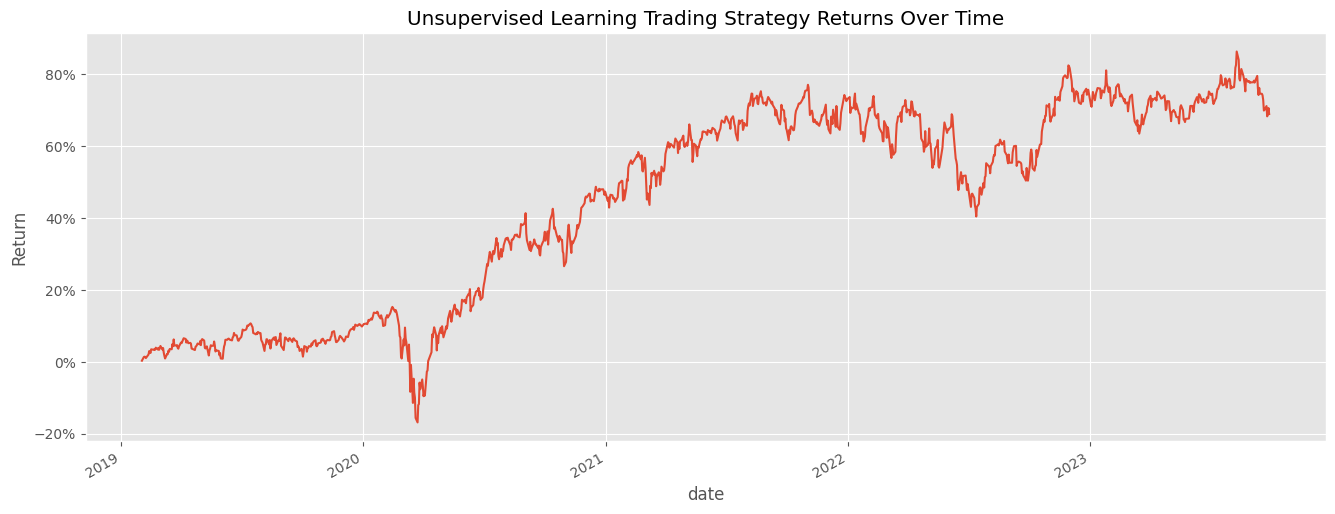

In [113]:
# Extract adjusted close prices from MultiIndex columns
adj_close = new_df['Adj Close']

# Calculate daily returns for each stock
daily_returns = adj_close.pct_change()

# Prepare for monthly portfolio optimization
monthly_dates = pd.date_range(start=daily_returns.index.min(), end=daily_returns.index.max(), freq='MS')
weights = {}

for i in range(len(monthly_dates) - 1):
    current_month = monthly_dates[i]
    next_month = monthly_dates[i + 1]

    try:
        # Select stocks for the current month
        selected_stocks = fixed_dates[current_month.strftime('%Y-%m-%d')]
        prices = adj_close.loc[current_month - pd.DateOffset(years=1):current_month, selected_stocks]
        prices = prices.dropna(axis=1, how='any')  # Drop stocks with missing data

        # Optimize portfolio weights
        try:
            weights[current_month] = optimize_weights(prices)
        except Exception as e:
            print(f"Optimization failed for {current_month}. Applying equal weights.")
            equal_weight = 1 / len(selected_stocks)
            weights[current_month] = {stock: equal_weight for stock in selected_stocks}
    except Exception as e:
        print(f"Data unavailable for {current_month}. Skipping.")
        continue

# Calculate daily portfolio returns
portfolio_returns = []

for date in daily_returns.index:
    # Identify the relevant month
    current_month = date.to_period('M').start_time
    if current_month in weights:
        # Extract weights and daily returns for the selected stocks
        stock_weights = pd.Series(weights[current_month])
        daily_stock_returns = daily_returns.loc[date, stock_weights.index]

        # Compute portfolio return for the day
        portfolio_return = (stock_weights * daily_stock_returns).sum()
        portfolio_returns.append({'date': date, 'portfolio_return': portfolio_return})

# Create a DataFrame for portfolio returns
portfolio_returns_df = pd.DataFrame(portfolio_returns).set_index('date')

import matplotlib.ticker as mtick

# Ensure cumulative returns are aligned to log scale
portfolio_cumulative_return = np.exp(np.log1p(portfolio_returns_df['portfolio_return']).cumsum()) - 1

# Plot the cumulative return
plt.style.use('ggplot')
portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16, 6))

# Add title and labels
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))  # Format y-axis as percentages
plt.ylabel('Return')

# Show the plot
plt.show()
